# Music Genre Classification task with neural networks from the PyTorch library.

The GTZAN dataset is a commonly used collection of audio tracks for research in music genre classification tasks. This dataset is widely utilized in the machine learning and audio processing communities for benchmarking algorithms and models.

## Overview

Number of Tracks: 1000\
Duration per Track: 30 seconds\
Genres: 10 (blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, rock)\
Tracks per Genre: 100

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import librosa

In [3]:
data = pd.read_csv('./datasets/genre-dataset/features_30_sec.csv')

In [59]:
#So i can see the full dat
# Adjust display settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [67]:
# Extract features and labels
features = data.drop(columns=['filename', 'label','length'])
labels = data['label']
#Number of features

In [27]:
# Convert to NumPy arrays
X = features.to_numpy()
y = labels.to_numpy()
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print (X_train.shape, X_test.shape)

(900, 57) (100, 57)


In [28]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [110]:
# Define the model
class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MusicGenreClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.3)
        
        self.out = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = self.out(x)
        return x

        x = self.out(x)
        return x

In [142]:
input_size = X_train.shape[1]
num_classes = len(set(y_train))
model = MusicGenreClassifier(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}')

# Save the trained model
torch.save(model.state_dict(), './music_genre_classifier.pth')

Epoch 1/50, Loss: 2.1099
Epoch 2/50, Loss: 1.7014
Epoch 3/50, Loss: 1.5791
Epoch 4/50, Loss: 1.4638
Epoch 5/50, Loss: 1.2883
Epoch 6/50, Loss: 1.2726
Epoch 7/50, Loss: 1.2088
Epoch 8/50, Loss: 1.1084
Epoch 9/50, Loss: 1.1364
Epoch 10/50, Loss: 0.9605
Epoch 11/50, Loss: 0.8680
Epoch 12/50, Loss: 0.9164
Epoch 13/50, Loss: 0.9382
Epoch 14/50, Loss: 0.8010
Epoch 15/50, Loss: 0.7683
Epoch 16/50, Loss: 0.8268
Epoch 17/50, Loss: 0.7135
Epoch 18/50, Loss: 0.8017
Epoch 19/50, Loss: 0.7743
Epoch 20/50, Loss: 0.7088
Epoch 21/50, Loss: 0.7135
Epoch 22/50, Loss: 0.7446
Epoch 23/50, Loss: 0.7422
Epoch 24/50, Loss: 0.7619
Epoch 25/50, Loss: 0.7237
Epoch 26/50, Loss: 0.5925
Epoch 27/50, Loss: 0.5614
Epoch 28/50, Loss: 0.5289
Epoch 29/50, Loss: 0.6200
Epoch 30/50, Loss: 0.5385
Epoch 31/50, Loss: 0.6951
Epoch 32/50, Loss: 0.5257
Epoch 33/50, Loss: 0.6422
Epoch 34/50, Loss: 0.5220
Epoch 35/50, Loss: 0.5960
Epoch 36/50, Loss: 0.5010
Epoch 37/50, Loss: 0.4750
Epoch 38/50, Loss: 0.6472
Epoch 39/50, Loss: 0.

In [143]:
#Load the saved model instead
try:
    model.load_state_dict(torch.load('./music_genre_classifier_0.001.pth'))
    print('Model Loaded')
except FileNotFoundError:
    print('File cannot be found')

File cannot be found


In [144]:
# Testing loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(targets.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8100


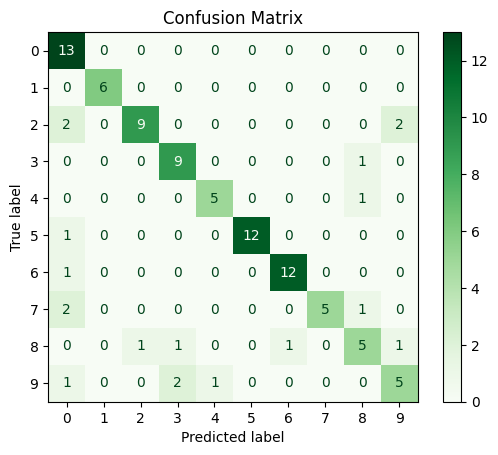

In [145]:
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()

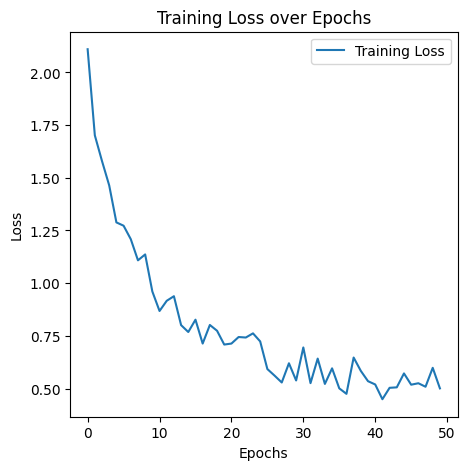

In [146]:
# Plotting training loss
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [147]:
# Paths for custom test data
wav_path_1 = './datasets/custom-music/enemyinside.wav'
wav_path_2 = './datasets/custom-music/getlucky.wav'
wav_path_3 = './datasets/custom-music/onemoretime.wav'
wav_path_4 = './datasets/custom-music/thrillisgone.wav'
audio_files=[wav_path_1,wav_path_2,wav_path_3,wav_path_4]

In [148]:
def extract_features(wav_path):
    #Convert to 22050
    y, sr = librosa.load(wav_path, sr=22050,duration=30.0)
    #Convert to mono
    y = librosa.to_mono(y)
    features = {}
    
    # Chroma
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_stft_mean'] = f"{np.mean(chroma_stft):.6f}"
    features['chroma_stft_var'] = f"{np.var(chroma_stft):.6f}"
    
    # RMS
    rms = librosa.feature.rms(y=y)
    features['rms_mean'] = f"{np.mean(rms):.6f}"
    features['rms_var'] = f"{np.var(rms):.6f}"
    
    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = f"{np.mean(spectral_centroid):.6f}"
    features['spectral_centroid_var'] = f"{np.var(spectral_centroid):.6f}"
    
    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_bandwidth_mean'] = f"{np.mean(spectral_bandwidth):.6f}"
    features['spectral_bandwidth_var'] = f"{np.var(spectral_bandwidth):.6f}"
    
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['rolloff_mean'] = f"{np.mean(rolloff):.6f}"
    features['rolloff_var'] = f"{np.var(rolloff):.6f}"
    
    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    features['zero_crossing_rate_mean'] = f"{np.mean(zero_crossing_rate):.6f}"
    features['zero_crossing_rate_var'] = f"{np.var(zero_crossing_rate):.6f}"
    
    # Harmonic and Percussive components
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    harmony = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    perceptr = librosa.feature.tonnetz(y=y_percussive, sr=sr)
    features['harmony_mean'] = f"{np.mean(harmony):.6f}"
    features['harmony_var'] = f"{np.var(harmony):.6f}"
    features['perceptr_mean'] = f"{np.mean(perceptr):.6f}"
    features['perceptr_var'] = f"{np.var(perceptr):.6f}"
    
    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo[0]
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(1, 21):
        features[f'mfcc{i}_mean'] = f"{np.mean(mfccs[i-1]):.6f}" 
        features[f'mfcc{i}_var'] = f"{np.var(mfccs[i-1]):.6f}"

    return features

features_arr=[]
for file in audio_files:
    test_features = extract_features(file)
    features_arr.append(list(test_features.values()))
print(f'Features extraced for {len(features_arr)} files')

Features extraced for 4 files


In [149]:
#Convert to np array and optimise
test_features_np = np.array(features_arr)
test_features_np_optimised = scaler.transform(test_features_np)
new_data_tensor = torch.tensor(test_features_np_optimised, dtype=torch.float32)

In [150]:
new_data_loader = DataLoader(new_data_tensor, batch_size=32, shuffle=False)
model.eval()
probabilities = []

with torch.no_grad():
    for inputs in new_data_loader:
        # Forward pass
        outputs = model(inputs)
        probabilities_batch = torch.softmax(outputs, dim=1)
        # Convert probabilities to numpy array
        probabilities_batch = probabilities_batch.numpy()
        # Append probabilities_batch to probabilities
        probabilities.append(probabilities_batch)

decoded_labels=label_encoder.inverse_transform(np.arange(10))
# Print probabilities and label encods
for batch_probs in probabilities:
    for j,probs in enumerate(batch_probs):
        print("\nProbabilities for",audio_files[j],'\n')
        for i, prob in enumerate(probs):
            print(f"{decoded_labels[i]}: {prob:.4f}")


Probabilities for ./datasets/custom-music/enemyinside.wav 

blues: 0.0098
classical: 0.0015
country: 0.0013
disco: 0.0185
hiphop: 0.0103
jazz: 0.0014
metal: 0.9184
pop: 0.0009
reggae: 0.0102
rock: 0.0277

Probabilities for ./datasets/custom-music/getlucky.wav 

blues: 0.0059
classical: 0.0244
country: 0.0136
disco: 0.1256
hiphop: 0.0533
jazz: 0.0280
metal: 0.0046
pop: 0.1173
reggae: 0.3946
rock: 0.2326

Probabilities for ./datasets/custom-music/onemoretime.wav 

blues: 0.0665
classical: 0.0060
country: 0.0032
disco: 0.0713
hiphop: 0.5155
jazz: 0.2577
metal: 0.0090
pop: 0.0211
reggae: 0.0434
rock: 0.0065

Probabilities for ./datasets/custom-music/thrillisgone.wav 

blues: 0.0078
classical: 0.0620
country: 0.0156
disco: 0.1081
hiphop: 0.0092
jazz: 0.4448
metal: 0.0081
pop: 0.0130
reggae: 0.0243
rock: 0.3071
